In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
import time
import os

from sklearn.model_selection import KFold
from keras.models import Model, Sequential
from keras import layers
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, LSTM
from tensorflow.keras import optimizers
from keras import regularizers


In [3]:
from ipynb.fs.full.DatasetManage import read_and_store_data
from ipynb.fs.full.FeatureExtraction import feature_extraction

Parameters

In [10]:
channels = ['FP1-F7', 'F7-T7','T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'seizure']

dataset = 'CHB_MIT'
csvImportFile = 'CHB.csv'
csvExportFile = 'CHB.csv'
sample_rate = 256
time_window = 2
step = time_window * sample_rate

test_ratio = 0.3 # ratio to split dataset into training and testing sets
val_ratio = 0.2 # ratio to split dataset into validation and training sets

pca_tolerance = 0.9 # desired percentage of variation in the data preserved

undersampling_rate = 0.2 # undersampling rate for Cluster Centroids

oversampling_neighbors = 11 # size of neighbourhood for K-nearest neighbours method

Create training and test sets

In [24]:
# Here we define a method to split the dataset into training and testing sets, also returning the train/test
# indexes for splitting the dataset into K folds for the K-fold cross validation

def trainTestData_1 (features, test_ratio, k_fold):
    x = features.loc[:, features.columns != 'seizure']
    y = features['seizure']
    x_tr, x_ts, y_tr, y_ts = train_test_split(x, y, test_size = test_ratio, shuffle = True, random_state=42)
    kf = KFold(n_splits = k_fold, shuffle = True)
    x_train = np.reshape(x_tr.values, (x_tr.shape[0], 1, x_tr.shape[1]))
    y_train = y_tr.values.astype(int)
    x_test = np.reshape(x_ts.values, (x_ts.shape[0], 1, x_ts.shape[1]))
    y_test = y_ts.values.astype(int)
    return x_train, x_test, y_train, y_test, kf

Create training, validation and test sets

In [13]:
# Here we define a method to split the dataset into training, validationa and testing sets

def trainTestData_2 (features, test_ratio, val_ratio):
    x = features.loc[:, features.columns != 'seizure']
    y = features['seizure']
    x_1, x_ts, y_1, y_ts = train_test_split(x, y, test_size = test_ratio, random_state=42)
    x_tr, x_v, y_tr, y_v = train_test_split(x_1, y_1, test_size = val_ratio, random_state=42)
    x_train = np.reshape(x_tr.values, (x_tr.shape[0], 1, x_tr.shape[1]))
    y_train = y_tr.values.astype(int)
    x_val = np.reshape(x_ts.values, (x_ts.shape[0], 1, x_ts.shape[1]))
    y_val = y_ts.values.astype(int)
    x_test = np.reshape(x_ts.values, (x_ts.shape[0], 1, x_ts.shape[1]))
    y_test = y_ts.values.astype(int)
    return x_train, x_test, y_train, y_test, x_val, y_val

Read and store data from the .csv file

In [7]:
print('Reading data from', csvImportFile)
df = pd.read_csv(csvImportFile, delimiter = ',', header = 0)

Reading data from CHB.csv


Feature Extraction 

In [ ]:
# We compute the features and save them in the Feature.csv file

ft = feature_extraction(df, sample_rate, step, pca_tolerance, undersampling_rate, oversampling_neighbors)

Train and Test process

In [11]:
ft = pd.read_csv("Features.csv", delimiter = ',', header = 0)

Dataset splitting without validation set

In [16]:
k_fold = 5
x_train, x_test, y_train, y_test, kf = trainTestData_1 (ft, test_ratio, k_fold)

Dataset splitting with validation set

In [14]:
x_train, x_test, y_train, y_test, x_val, y_val = trainTestData_2 (ft, test_ratio, val_ratio)

Model Checkpoint

In [20]:
dir_name = 'model_checkpoint'

if not os.path.exists(dir_name):
        os.makedirs(dir_name)

save_path = os.path.join(dir_name, 'Vanilla_RNN.h5')

callbacks_list = tf.keras.callbacks.ModelCheckpoint(filepath=save_path, monitor="val_loss", verbose=1, save_best_only=True)

Stochastic Gradient Descent Optimizer

In [28]:
def optimizer_SGD (initial_learning_rate, decay_steps, decay_rate):
    # We define the optimizer with an initial learning rate
    optimizer = tf.keras.optimizers.SGD(learning_rate=initial_learning_rate)

    # We define the larning rate schedule with an exponential decay, specifying the number of decay steps and the decay rate
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps, decay_rate, staircase=True)
    
    return optimizer, lr_schedule

Plot methods

In [29]:
def plot_2 (history):
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochs = range(len(train_loss))

    plt.figure()
    plt.plot(epochs, train_loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.figure()
    plt.plot(epochs, train_acc, label='Training accuracy')
    plt.plot(epochs, val_acc, label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.show()

    model.summary()

Vanilla RNN: model 1

Epoch 1/350
38/49 [======================>.......] - ETA: 0s - loss: 0.9435 - accuracy: 0.3388 
Epoch 1: val_loss improved from inf to 0.85379, saving model to model_checkpoint\Vanilla_RNN.h5
49/49 [==============================] - 1s 8ms/step - loss: 0.9274 - accuracy: 0.3520 - val_loss: 0.8538 - val_accuracy: 0.3988 - lr: 0.0010
Epoch 2/350
41/49 [========================>.....] - ETA: 0s - loss: 0.7767 - accuracy: 0.4970
Epoch 2: val_loss improved from 0.85379 to 0.71965, saving model to model_checkpoint\Vanilla_RNN.h5
49/49 [==============================] - 0s 4ms/step - loss: 0.7556 - accuracy: 0.5306 - val_loss: 0.7197 - val_accuracy: 0.5833 - lr: 0.0010
Epoch 3/350
48/49 [============================>.] - ETA: 0s - loss: 0.6470 - accuracy: 0.6719
Epoch 3: val_loss improved from 0.71965 to 0.62997, saving model to model_checkpoint\Vanilla_RNN.h5
49/49 [==============================] - 0s 4ms/step - loss: 0.6432 - accuracy: 0.6735 - val_loss: 0.6300 - val_accuracy: 0.6429 - lr:

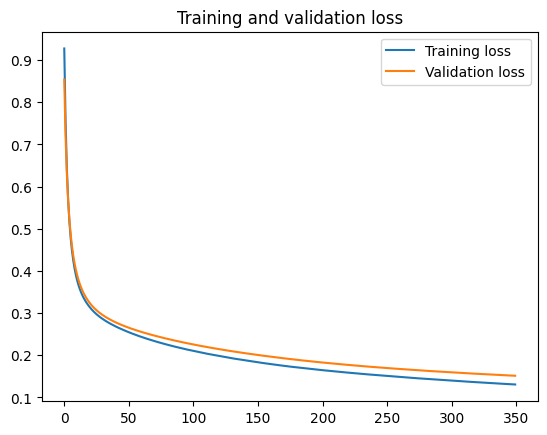

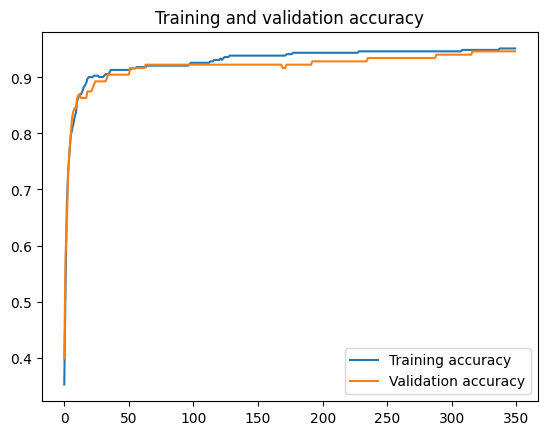

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 32)                3808      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,841
Trainable params: 3,841
Non-trainable params: 0
_________________________________________________________________
6/6 [==============================] - 0s 2ms/step - loss: 0.1515 - accuracy: 0.9464
Test Loss: 0.15146104991436005
Test Accuracy: 0.9464285969734192


In [31]:
dir_name = 'model_checkpoint'
if not os.path.exists(dir_name):
        os.makedirs(dir_name)
save_path = os.path.join(dir_name, 'Vanilla_RNN.h5')

callbacks_list = tf.keras.callbacks.ModelCheckpoint(filepath=save_path, monitor="val_loss", verbose=1, save_best_only=True)

# Definition of the model
model = Sequential()
model.add(SimpleRNN(32, input_shape=(None, x_train.shape[-1])))  
model.add(Dense(1, activation='sigmoid'))

# Compile the model with a SGD optimizer with an exponential decaying learning rate
optimizer, lr_schedule = optimizer_SGD(0.001, 1000, 0.1)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Training of the model
history = model.fit(x_train, y_train, epochs=350, batch_size=8, validation_data=(x_val, y_val), callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_schedule), callbacks_list])

"""
# optimizer "adam"
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

"""

plot_2(history)

# Evaluation of the model on the testing set
loss, accuracy = model.evaluate(x_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Vanilla RNN with Adam optimizer

Epoch 1/350
27/49 [===============>..............] - ETA: 0s - loss: 0.4740 - accuracy: 0.7963 
Epoch 1: val_loss improved from inf to 0.30712, saving model to model_checkpoint\Vanilla_RNN_Adam.h5
49/49 [==============================] - 2s 10ms/step - loss: 0.4508 - accuracy: 0.8010 - val_loss: 0.3071 - val_accuracy: 0.8810
Epoch 2/350
34/49 [===================>..........] - ETA: 0s - loss: 0.2982 - accuracy: 0.8971
Epoch 2: val_loss improved from 0.30712 to 0.25451, saving model to model_checkpoint\Vanilla_RNN_Adam.h5
49/49 [==============================] - 0s 5ms/step - loss: 0.2900 - accuracy: 0.9005 - val_loss: 0.2545 - val_accuracy: 0.8929
Epoch 3/350
48/49 [============================>.] - ETA: 0s - loss: 0.2375 - accuracy: 0.9115
Epoch 3: val_loss improved from 0.25451 to 0.22853, saving model to model_checkpoint\Vanilla_RNN_Adam.h5
49/49 [==============================] - 0s 6ms/step - loss: 0.2385 - accuracy: 0.9107 - val_loss: 0.2285 - val_accuracy: 0.9048
Epoch 4/350
45/

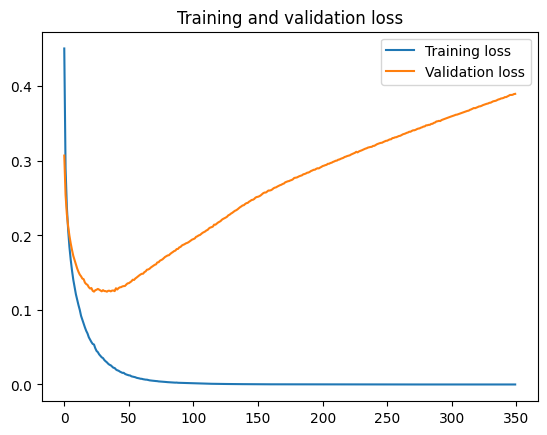

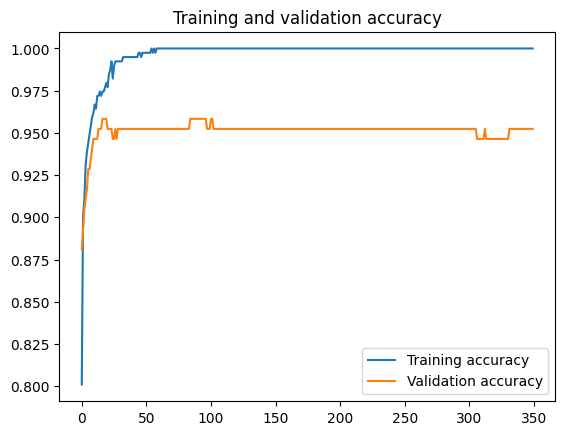

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 32)                3808      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,841
Trainable params: 3,841
Non-trainable params: 0
_________________________________________________________________
6/6 [==============================] - 0s 2ms/step - loss: 0.3899 - accuracy: 0.9524
Test Loss: 0.3898967206478119
Test Accuracy: 0.9523809552192688


In [35]:
dir_name = 'model_checkpoint'
if not os.path.exists(dir_name):
        os.makedirs(dir_name)
save_path = os.path.join(dir_name, 'Vanilla_RNN_Adam.h5')

callbacks_list = tf.keras.callbacks.ModelCheckpoint(filepath=save_path, monitor="val_loss", verbose=1, save_best_only=True)

# Definition of the model
model = Sequential()
model.add(SimpleRNN(32, input_shape=(None, x_train.shape[-1])))  
model.add(Dense(1, activation='sigmoid'))

# Compile the model with Adam optimizer 
optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Training of the model
history = model.fit(x_train, y_train, epochs=350, batch_size=8, validation_data=(x_val, y_val), callbacks=[callbacks_list])

plot_2(history)

# Evaluation of the model on the testing set
loss, accuracy = model.evaluate(x_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Plot method for K-fold validation

In [42]:
def plot_1 (train_loss, train_acc, val_loss, val_acc):
    
    avg_train_loss = np.mean(train_loss, axis=0)
    avg_train_acc = np.mean(train_acc, axis=0)
    avg_val_loss = np.mean(val_loss, axis=0)
    avg_val_acc = np.mean(train_acc, axis=0)

    # Plot delle curve di apprendimento mediate sulle K fold

    epochs = range(1, len(train_loss[0]) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, avg_train_loss, label='Training loss')
    plt.plot(epochs, avg_val_loss, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Avg_loss')
    plt.title('Average train and validation loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, avg_train_acc, label='Training accuracy')
    plt.plot(epochs, avg_val_acc, label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Avg_accuracy')
    plt.title('Average train and validation accuracy')
    plt.legend()
    plt.show()

    model.summary()

K-fold cross validation for the Vanilla RNN

Implementing vanilla RNN with K-fold

Epoch 1: val_loss improved from inf to 0.68943, saving model to model_checkpoint\Vanilla_RNN_K-fold.h5

Epoch 2: val_loss improved from 0.68943 to 0.61284, saving model to model_checkpoint\Vanilla_RNN_K-fold.h5

Epoch 3: val_loss improved from 0.61284 to 0.55715, saving model to model_checkpoint\Vanilla_RNN_K-fold.h5

Epoch 4: val_loss improved from 0.55715 to 0.51534, saving model to model_checkpoint\Vanilla_RNN_K-fold.h5

Epoch 5: val_loss improved from 0.51534 to 0.48297, saving model to model_checkpoint\Vanilla_RNN_K-fold.h5

Epoch 6: val_loss improved from 0.48297 to 0.45693, saving model to model_checkpoint\Vanilla_RNN_K-fold.h5

Epoch 7: val_loss improved from 0.45693 to 0.43575, saving model to model_checkpoint\Vanilla_RNN_K-fold.h5

Epoch 8: val_loss improved from 0.43575 to 0.41810, saving model to model_checkpoint\Vanilla_RNN_K-fold.h5

Epoch 9: val_loss improved from 0.41810 to 0.40304, saving model to model_checkpoint\Vanilla_RNN_K-fol

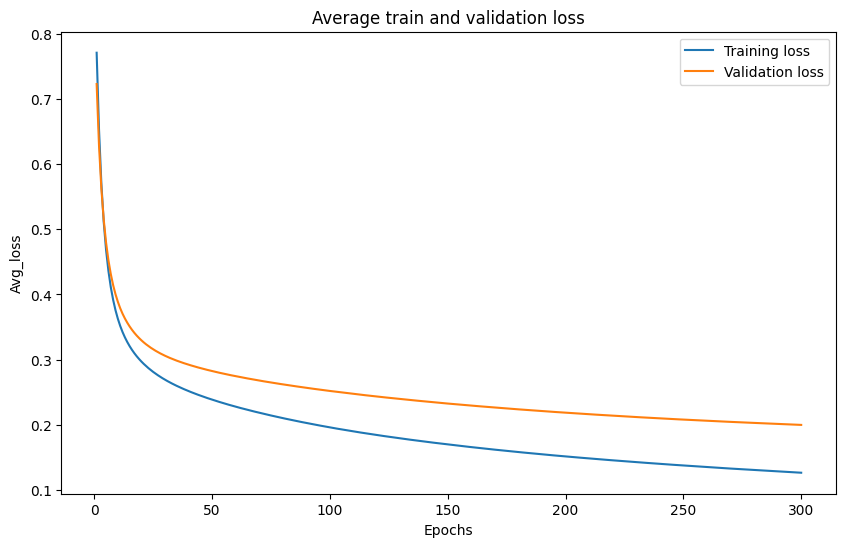

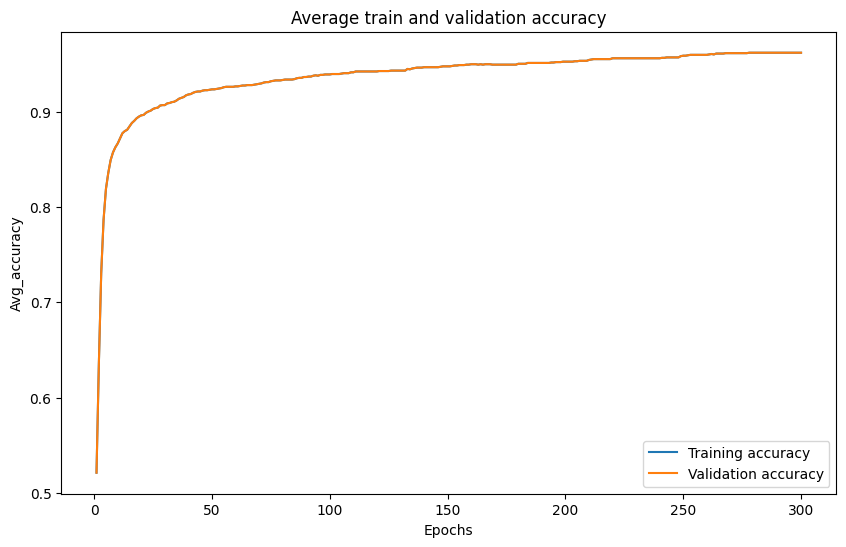

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_10 (SimpleRNN)   (None, 32)                3808      
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 3,841
Trainable params: 3,841
Non-trainable params: 0
_________________________________________________________________
Average accuracy: 0.9179
Average loss: 0.1999


In [43]:
dir_name = 'model_checkpoint'
if not os.path.exists(dir_name):
        os.makedirs(dir_name)
save_path = os.path.join(dir_name, 'Vanilla_RNN_K-fold.h5')

callbacks_list = tf.keras.callbacks.ModelCheckpoint(filepath=save_path, monitor="val_loss", verbose=1, save_best_only=True)

k_fold = 5 # number of folds for the K-fold cross validation
x_train, x_test, y_train, y_test, kf = trainTestData_1 (ft, test_ratio, k_fold)

# Arrays to store the learning curves at each k-th iteration
val_loss = []
val_acc = []
train_loss = []
train_acc = []
test_loss = []
test_acc = []

print('Implementing vanilla RNN with K-fold')
start = time.time()
for train, test in kf.split(ft):
    x_train = ft.iloc[train,:ft.shape[1]-1]
    x_train = np.reshape(x_train.values, (x_train.shape[0], 1, x_train.shape[1]))
    y_train = ft.loc[train,'seizure'].values.astype(int)
    x_test = ft.iloc[test,:ft.shape[1]-1]
    x_test = np.reshape(x_test.values, (x_test.shape[0], 1, x_test.shape[1]))
    y_test = ft.loc[test,'seizure'].values.astype(int)

    # Definition of the model
    model = Sequential()
    model.add(SimpleRNN(32, input_shape=(None, x_train.shape[-1])))  
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model with a SGD optimizer with an exponential decaying learning rate
    optimizer, lr_schedule = optimizer_SGD(0.001, 1000, 0.1)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Training of the model
    history = model.fit(x_train, y_train, batch_size = 10, epochs = 300, verbose = 0, validation_data=(x_test,y_test), callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_schedule), callbacks_list])

    # Store the metrics values for each epoch and for each fold
    train_loss.append(history.history['loss'])
    train_acc.append(history.history['accuracy'])
    val_loss.append(history.history['val_loss'])
    val_acc.append(history.history['val_accuracy'])

    # Evaluation of the model
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    test_acc.append(accuracy)
    test_loss.append(loss)

    # Print of the loss and accuracy scores at the end of each fold
    print("Loss: {:.4f}, Accuracy: {:.2f}%".format(loss, accuracy * 100))

end = time.time()
t = round(end - start,2)
print('Vanilla_RNN finished in', t,'sec\n')

# Plot of the average learning curves
plot_1(train_loss, train_acc, val_loss, val_acc)

# Calculate average performance
avg_accuracy = np.mean(test_acc)
avg_loss = np.mean(test_loss)
print(f'Average accuracy: {avg_accuracy:.4f}')
print(f'Average loss: {avg_loss:.4f}')

Prova 0

Implementing vanilla RNN with K-fold
Epoch 1/300
45/45 [==============================] - 1s 7ms/step - loss: 1.2282 - accuracy: 0.2701 - val_loss: 1.0591 - val_accuracy: 0.3393 - lr: 0.0010
Epoch 2/300
45/45 [==============================] - 0s 4ms/step - loss: 0.9764 - accuracy: 0.3906 - val_loss: 0.8644 - val_accuracy: 0.4464 - lr: 0.0010
Epoch 3/300
45/45 [==============================] - 0s 4ms/step - loss: 0.8002 - accuracy: 0.5558 - val_loss: 0.7287 - val_accuracy: 0.5804 - lr: 0.0010
Epoch 4/300
45/45 [==============================] - 0s 7ms/step - loss: 0.6783 - accuracy: 0.6696 - val_loss: 0.6348 - val_accuracy: 0.6696 - lr: 0.0010
Epoch 5/300
45/45 [==============================] - 0s 8ms/step - loss: 0.5928 - accuracy: 0.7299 - val_loss: 0.5690 - val_accuracy: 0.7232 - lr: 0.0010
Epoch 6/300
45/45 [==============================] - 0s 5ms/step - loss: 0.5310 - accuracy: 0.7612 - val_loss: 0.5222 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 7/300
45/45 [====================

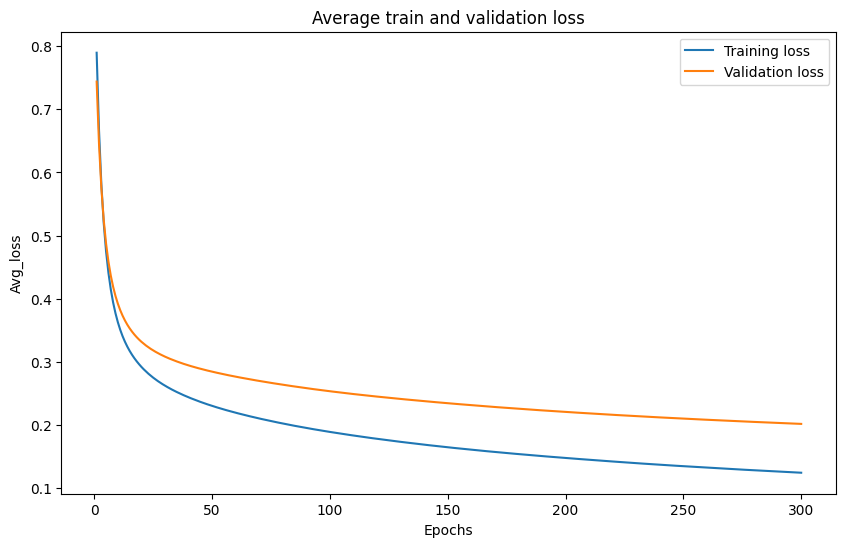

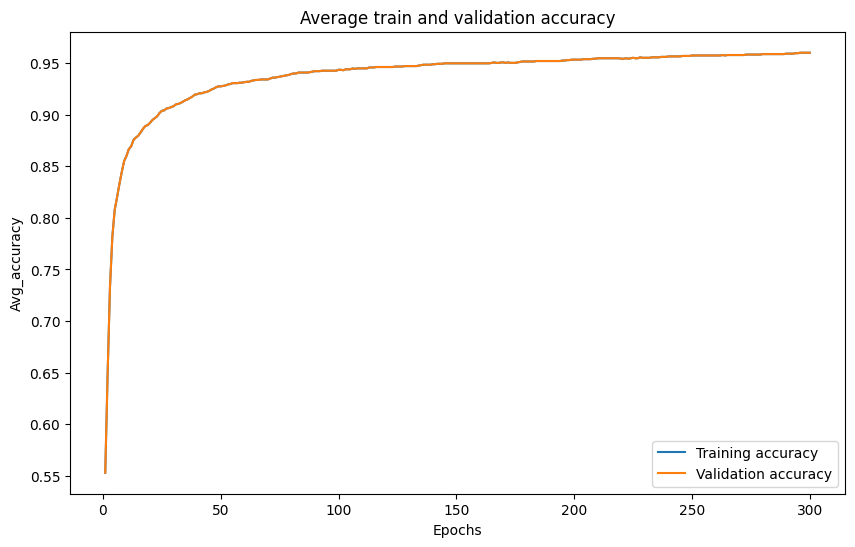

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_20 (SimpleRNN)   (None, 32)                3808      
                                                                 
 dense_20 (Dense)            (None, 1)                 33        
                                                                 
Total params: 3,841
Trainable params: 3,841
Non-trainable params: 0
_________________________________________________________________
Average accuracy: 0.9196
Average loss: 0.2018


In [52]:
k_fold = 5 # number of folds for the K-fold cross validation
x_train, x_test, y_train, y_test, kf = trainTestData_1 (ft, test_ratio, k_fold)

# Arrays to store the learning curves at each k-th iteration
val_loss = []
val_acc = []
train_loss = []
train_acc = []
test_loss = []
test_acc = []

print('Implementing vanilla RNN with K-fold')
start = time.time()
for train, test in kf.split(ft):
    x_train = ft.iloc[train,:ft.shape[1]-1]
    x_train = np.reshape(x_train.values, (x_train.shape[0], 1, x_train.shape[1]))
    y_train = ft.loc[train,'seizure'].values.astype(int)
    x_test = ft.iloc[test,:ft.shape[1]-1]
    x_test = np.reshape(x_test.values, (x_test.shape[0], 1, x_test.shape[1]))
    y_test = ft.loc[test,'seizure'].values.astype(int)

    # Definition of the model
    model = Sequential()
    model.add(SimpleRNN(32, input_shape=(None, x_train.shape[-1])))  
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model with a SGD optimizer with an exponential decaying learning rate
    optimizer, lr_schedule = optimizer_SGD(0.001, 1000, 0.1)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Training of the model
    history = model.fit(x_train, y_train, batch_size = 10, epochs = 300, verbose = 1, validation_data=(x_test,y_test), callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_schedule)])

    # Store the metrics values for each epoch and for each fold
    train_loss.append(history.history['loss'])
    train_acc.append(history.history['accuracy'])
    val_loss.append(history.history['val_loss'])
    val_acc.append(history.history['val_accuracy'])

    # Evaluation of the model
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    test_acc.append(accuracy)
    test_loss.append(loss)

    # Print of the loss and accuracy scores at the end of each fold
    print("Loss: {:.4f}, Accuracy: {:.2f}%".format(loss, accuracy * 100))

end = time.time()
t = round(end - start,2)
print('Vanilla_RNN finished in', t,'sec\n')

# Plot of the average learning curves
plot_1(train_loss, train_acc, val_loss, val_acc)

# Calculate average performance
avg_accuracy = np.mean(test_acc)
avg_loss = np.mean(test_loss)
print(f'Average accuracy: {avg_accuracy:.4f}')
print(f'Average loss: {avg_loss:.4f}')

K = 10

Implementing vanilla RNN with K-fold

Epoch 1: val_loss improved from inf to 0.46640, saving model to model_checkpoint\Vanilla_RNN_10-fold.h5

Epoch 2: val_loss improved from 0.46640 to 0.43242, saving model to model_checkpoint\Vanilla_RNN_10-fold.h5

Epoch 3: val_loss improved from 0.43242 to 0.40616, saving model to model_checkpoint\Vanilla_RNN_10-fold.h5

Epoch 4: val_loss improved from 0.40616 to 0.38537, saving model to model_checkpoint\Vanilla_RNN_10-fold.h5

Epoch 5: val_loss improved from 0.38537 to 0.36865, saving model to model_checkpoint\Vanilla_RNN_10-fold.h5

Epoch 6: val_loss improved from 0.36865 to 0.35482, saving model to model_checkpoint\Vanilla_RNN_10-fold.h5

Epoch 7: val_loss improved from 0.35482 to 0.34320, saving model to model_checkpoint\Vanilla_RNN_10-fold.h5

Epoch 8: val_loss improved from 0.34320 to 0.33319, saving model to model_checkpoint\Vanilla_RNN_10-fold.h5

Epoch 9: val_loss improved from 0.33319 to 0.32475, saving model to model_checkpoint\Vanilla_R

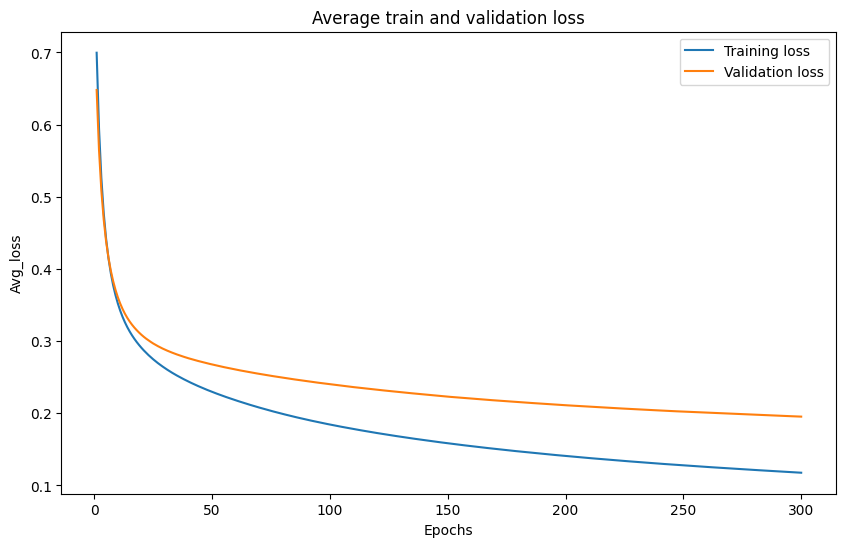

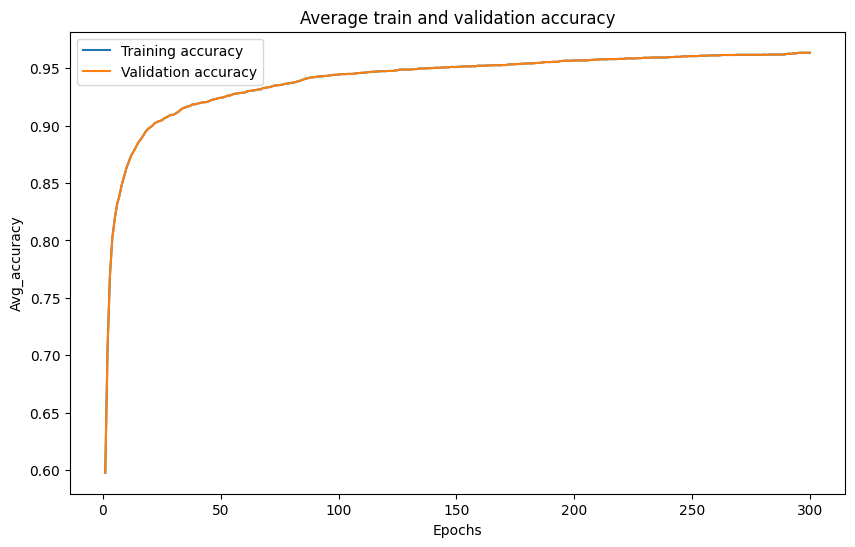

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_30 (SimpleRNN)   (None, 32)                3808      
                                                                 
 dense_30 (Dense)            (None, 1)                 33        
                                                                 
Total params: 3,841
Trainable params: 3,841
Non-trainable params: 0
_________________________________________________________________
Average accuracy: 0.9339
Average loss: 0.1954


In [54]:
dir_name = 'model_checkpoint'
if not os.path.exists(dir_name):
        os.makedirs(dir_name)
save_path = os.path.join(dir_name, 'Vanilla_RNN_10-fold.h5')

callbacks_list = tf.keras.callbacks.ModelCheckpoint(filepath=save_path, monitor="val_loss", verbose=1, save_best_only=True)

k_fold = 10 # number of folds for the K-fold cross validation
x_train, x_test, y_train, y_test, kf = trainTestData_1 (ft, test_ratio, k_fold)

# Arrays to store the learning curves at each k-th iteration
val_loss = []
val_acc = []
train_loss = []
train_acc = []
test_loss = []
test_acc = []

print('Implementing vanilla RNN with K-fold')
start = time.time()
for train, test in kf.split(ft):
    x_train = ft.iloc[train,:ft.shape[1]-1]
    x_train = np.reshape(x_train.values, (x_train.shape[0], 1, x_train.shape[1]))
    y_train = ft.loc[train,'seizure'].values.astype(int)
    x_test = ft.iloc[test,:ft.shape[1]-1]
    x_test = np.reshape(x_test.values, (x_test.shape[0], 1, x_test.shape[1]))
    y_test = ft.loc[test,'seizure'].values.astype(int)

    # Definition of the model
    model = Sequential()
    model.add(SimpleRNN(32, input_shape=(None, x_train.shape[-1])))  
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model with a SGD optimizer with an exponential decaying learning rate
    optimizer, lr_schedule = optimizer_SGD(0.001, 1000, 0.1)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Training of the model
    history = model.fit(x_train, y_train, batch_size = 10, epochs = 300, verbose = 0, validation_data=(x_test,y_test), callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_schedule), callbacks_list])

    # Store the metrics values for each epoch and for each fold
    train_loss.append(history.history['loss'])
    train_acc.append(history.history['accuracy'])
    val_loss.append(history.history['val_loss'])
    val_acc.append(history.history['val_accuracy'])

    # Evaluation of the model
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    test_acc.append(accuracy)
    test_loss.append(loss)

    # Print of the loss and accuracy scores at the end of each fold
    print("Loss: {:.4f}, Accuracy: {:.2f}%".format(loss, accuracy * 100))

end = time.time()
t = round(end - start,2)
print('Vanilla_RNN finished in', t,'sec\n')

# Plot of the average learning curves
plot_1(train_loss, train_acc, val_loss, val_acc)

# Calculate average performance
avg_accuracy = np.mean(test_acc)
avg_loss = np.mean(test_loss)
print(f'Average accuracy: {avg_accuracy:.4f}')
print(f'Average loss: {avg_loss:.4f}')

Multiple plots

In [ ]:
# Plot the average loss curve
plt.figure()
for i in range(5):
    plt.plot(train_loss[i])
plt.title('Training Loss - All Folds')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
for i in range(5):
    plt.plot(train_acc[i])
plt.title('Training Accuracy - All Folds')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

LSTM

Epoch 1/1000
40/40 [==============================] - 3s 22ms/step - loss: 0.7058 - accuracy: 0.4856 - val_loss: 0.7151 - val_accuracy: 0.4643 - lr: 0.0010
Epoch 2/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.6933 - accuracy: 0.5304 - val_loss: 0.7023 - val_accuracy: 0.5476 - lr: 0.0010
Epoch 3/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.6808 - accuracy: 0.5847 - val_loss: 0.6900 - val_accuracy: 0.5833 - lr: 0.0010
Epoch 4/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.6688 - accuracy: 0.6006 - val_loss: 0.6782 - val_accuracy: 0.5952 - lr: 0.0010
Epoch 5/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.6572 - accuracy: 0.6581 - val_loss: 0.6671 - val_accuracy: 0.6369 - lr: 0.0010
Epoch 6/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.6463 - accuracy: 0.6901 - val_loss: 0.6562 - val_accuracy: 0.6726 - lr: 0.0010
Epoch 7/1000
40/40 [==============================] - 0s 4ms/step - l

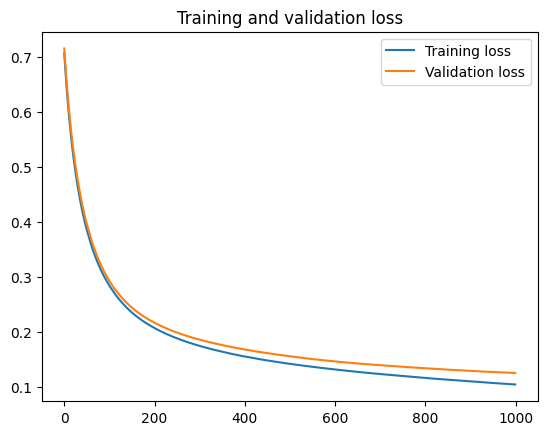

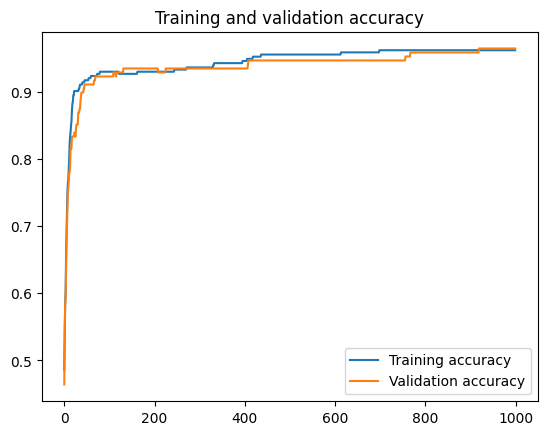

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 64)                38656     
                                                                 
 dense_55 (Dense)            (None, 1)                 65        
                                                                 
Total params: 38,721
Trainable params: 38,721
Non-trainable params: 0
_________________________________________________________________


In [71]:
# Definizione del modello LSTM

model = Sequential()
model.add(LSTM(64, input_shape=(None, x_train.shape[-1]))) 
model.add(Dense(1, activation='sigmoid'))

# Definisco l'ottimizzatore con il learning rate iniziale
initial_learning_rate = 0.001
optimizer = tf.keras.optimizers.SGD(learning_rate=initial_learning_rate)

# Definisco il learning rate schedule con decay lineare
decay_steps = 1000  # Numero di passi di addestramento dopo i quali applicare il decay
decay_rate = 0.1  # Tasso di decay
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps, decay_rate, staircase=True)

# Compilazione del modello
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

"""
# optimizer "adam"
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

"""

# Addestramento del modello con il learning rate modificato
history = model.fit(x_train, y_train, epochs=1000, batch_size=8, validation_data=(x_val, y_val), callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_schedule)])

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(train_loss))

plt.figure()
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

model.summary()

Evaluation of the LSTM model on test set

In [73]:
# Valutazione del modello
loss, accuracy = model.evaluate(x_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

6/6 [==============================] - 0s 2ms/step - loss: 0.1259 - accuracy: 0.9643
Test Loss: 0.12585870921611786
Test Accuracy: 0.9642857313156128


K-fold cross validation on LSTM model

In [13]:

"""
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
"""

k = 8  # numero di fold
kf = KFold(n_splits=k, shuffle = True)

# Array per memorizzare le curve di apprendimento
val_loss = []
val_acc = []
train_loss = []
train_acc = []

test_acc = []
test_loss = []

f = pd.DataFrame(columns = perfInd)
print('Implementing LSTM with k-fold')
start = time.time()
for train, test in kf.split(ft):
    x_train = ft.iloc[train,:ft.shape[1]-1]
    x_train = np.reshape(x_train.values, (x_train.shape[0], 1, x_train.shape[1]))
    y_train = ft.loc[train,'seizure'].values.astype(int)
    x_test = ft.iloc[test,:ft.shape[1]-1]
    x_test = np.reshape(x_test.values, (x_test.shape[0], 1, x_test.shape[1]))
    y_test = ft.loc[test,'seizure'].values.astype(int)

    model = Sequential()
    model.add(LSTM(64, input_shape=(None, x_train.shape[-1]))) 
    model.add(Dense(1, activation='sigmoid'))

    # Definisco l'ottimizzatore con il learning rate iniziale
    initial_learning_rate = 0.001
    optimizer = tf.keras.optimizers.SGD(learning_rate=initial_learning_rate)

    # Definisco il learning rate schedule con decay lineare
    decay_steps = 1000  # Numero di passi di addestramento dopo i quali applicare il decay
    decay_rate = 0.1  # Tasso di decay
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps, decay_rate, staircase=True)

    # Compilazione del modello
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(x_train, y_train, batch_size = 10, epochs = 1000, verbose = 0, validation_data=(x_test,y_test), callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_schedule)])

    train_loss.append(history.history['loss'])
    train_acc.append(history.history['accuracy'])
    val_loss.append(history.history['val_loss'])
    val_acc.append(history.history['val_accuracy'])

    # Valuta il modello
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    test_acc.append(accuracy)
    test_loss.append(loss)

    # Stampa i risultati di accuracy e loss per la k-esima fold
    print("Loss: {:.4f}, Accuracy: {:.2f}%".format(loss, accuracy * 100))

end = time.time()
t = round(end - start,2)
print('LSTM finished in', t,'sec\n')

 # Calculate average performance
avg_accuracy = np.mean(test_acc)
avg_loss = np.mean(test_loss)
print(f'Average accuracy: {avg_accuracy:.4f}')
print(f'Average loss: {avg_loss:.4f}')



Implementing LSTM with k-fold
Loss: 0.1783, Accuracy: 91.43%
Loss: 0.1643, Accuracy: 94.29%
Loss: 0.1497, Accuracy: 97.14%
Loss: 0.0685, Accuracy: 98.57%
Loss: 0.1639, Accuracy: 92.86%
Loss: 0.1237, Accuracy: 94.29%
Loss: 0.1354, Accuracy: 94.29%
Loss: 0.1707, Accuracy: 92.86%
LSTM finished in 1178.66 sec

Average accuracy: 0.9446
Average loss: 0.1443


(1000,)


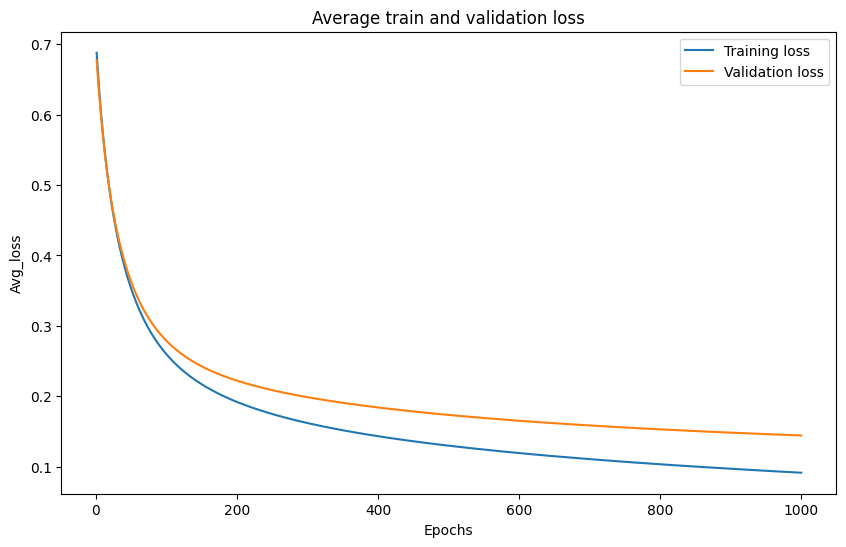

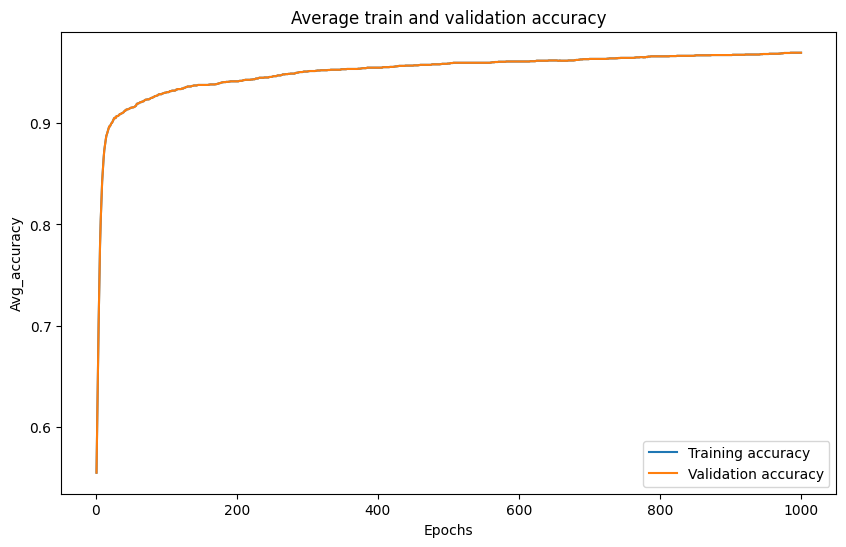

In [15]:
avg_train_loss = np.mean(train_loss, axis=0)
avg_train_acc = np.mean(train_acc, axis=0)
avg_val_loss = np.mean(val_loss, axis=0)
avg_val_acc = np.mean(train_acc, axis=0)
print(np.shape(avg_train_loss))

# Plot delle curve di apprendimento mediate sulle K fold

epochs = range(1, len(train_loss[0]) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, avg_train_loss, label='Training loss')
plt.plot(epochs, avg_val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Avg_loss')
plt.title('Average train and validation loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(epochs, avg_train_acc, label='Training accuracy')
plt.plot(epochs, avg_val_acc, label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Avg_accuracy')
plt.title('Average train and validation accuracy')
plt.legend()
plt.show()

LSTM greco

Epoch 1/1000
40/40 [==============================] - 3s 15ms/step - loss: 2.6474 - accuracy: 0.5112 - val_loss: 2.6343 - val_accuracy: 0.5238 - lr: 0.0010
Epoch 2/1000
40/40 [==============================] - 0s 4ms/step - loss: 2.6346 - accuracy: 0.5559 - val_loss: 2.6236 - val_accuracy: 0.5833 - lr: 0.0010
Epoch 3/1000
40/40 [==============================] - 0s 5ms/step - loss: 2.6199 - accuracy: 0.5847 - val_loss: 2.6133 - val_accuracy: 0.6429 - lr: 0.0010
Epoch 4/1000
40/40 [==============================] - 0s 5ms/step - loss: 2.6143 - accuracy: 0.6038 - val_loss: 2.6029 - val_accuracy: 0.6786 - lr: 0.0010
Epoch 5/1000
40/40 [==============================] - 0s 4ms/step - loss: 2.5996 - accuracy: 0.6869 - val_loss: 2.5929 - val_accuracy: 0.7381 - lr: 0.0010
Epoch 6/1000
40/40 [==============================] - 0s 5ms/step - loss: 2.5898 - accuracy: 0.7125 - val_loss: 2.5827 - val_accuracy: 0.7857 - lr: 0.0010
Epoch 7/1000
40/40 [==============================] - 0s 5ms/step - l

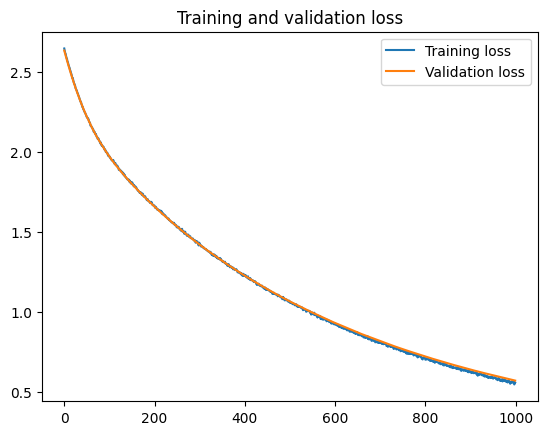

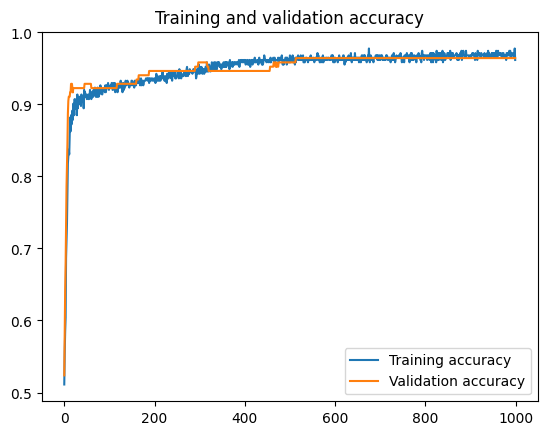

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 128)               110080    
                                                                 
 dropout_20 (Dropout)        (None, 128)               0         
                                                                 
 dense_50 (Dense)            (None, 32)                4128      
                                                                 
 dropout_21 (Dropout)        (None, 32)                0         
                                                                 
 dense_51 (Dense)            (None, 1)                 33        
                                                                 
Total params: 114,241
Trainable params: 114,241
Non-trainable params: 0
_________________________________________________________________
6/6 [==============================] - 1s 2ms/s

In [64]:
# Definisco l'ottimizzatore con il learning rate iniziale
initial_learning_rate = 0.001
optimizer = tf.keras.optimizers.SGD(learning_rate=initial_learning_rate)

# Definisco il learning rate schedule con decay lineare
decay_steps = 1000  # Numero di passi di addestramento dopo i quali applicare il decay
decay_rate = 0.1  # Tasso di decay
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps, decay_rate, staircase=True)
                                                             
model = Sequential()
lstm_units = 128
dense_units = 32

# kernel_regularizer=regularizers.l2(1e-3)

model.add(LSTM(lstm_units, kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(dropout_percentage))
model.add(Dense(dense_units, activation = 'relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(dropout_percentage/2))
model.add(Dense(1, activation = 'sigmoid', kernel_regularizer=regularizers.l2(1e-3)))

# Compilazione del modello
# model.compile(optimizer = Adam(learning_rate = 1e-3), loss = loss_function, metrics = metric)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Addestramento del modello con il learning rate modificato
history = model.fit(x_train, y_train, epochs=1000, batch_size=8, validation_data=(x_val, y_val), callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_schedule)])

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(train_loss))

plt.figure()
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

model.summary()

# Valutazione del modello
loss, accuracy = model.evaluate(x_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

K-fold con early stopping

In [14]:

"""
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
"""

k = 5  # numero di fold
kf = KFold(n_splits=k, shuffle = True)

# Array per memorizzare le curve di apprendimento
test_loss = []
test_acc = []

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)

f = pd.DataFrame(columns = perfInd)
print('Implementing vanilla RNN with k-fold')
start = time.time()
for train, test in kf.split(ft):
    x_train = ft.iloc[train,:ft.shape[1]-1]
    x_train = np.reshape(x_train.values, (x_train.shape[0], 1, x_train.shape[1]))
    y_train = ft.loc[train,'seizure'].values.astype(int)
    x_test = ft.iloc[test,:ft.shape[1]-1]
    x_test = np.reshape(x_test.values, (x_test.shape[0], 1, x_test.shape[1]))
    y_test = ft.loc[test,'seizure'].values.astype(int)

    print(x_train.shape)
    print(x_test.shape)
    print(y_train.shape)
    print(y_test.shape)


    model = Sequential()
    model.add(SimpleRNN(32, input_shape=(None, x_train.shape[-1])))  # "timesteps" rappresenta il numero di istanti temporali nel segnale EEG, "features" è il numero di caratteristiche per ciascun istante temporale
    model.add(Dropout(0.18))
    model.add(Dense(1, activation='sigmoid'))

    # Definisco l'ottimizzatore con il learning rate iniziale
    initial_learning_rate = 0.001
    optimizer = tf.keras.optimizers.SGD(learning_rate=initial_learning_rate)

    # Definisco il learning rate schedule con decay lineare
    decay_steps = 1000  # Numero di passi di addestramento dopo i quali applicare il decay
    decay_rate = 0.1  # Tasso di decay
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps, decay_rate, staircase=True)

    # Compilazione del modello
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(x_train, y_train, batch_size = 10, epochs = 200, verbose = 1, validation_data=(x_test,y_test), callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_schedule), early_stopping])
    # Valuta il modello
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    test_acc.append(accuracy)
    test_loss.append(loss)

    # Stampa i risultati di accuracy e loss per la k-esima fold
    print("Loss: {:.4f}, Accuracy: {:.2f}%".format(loss, accuracy * 100))

    # train_loss.append(history.history['loss'])
    # train_acc.append(history.history['accuracy'])

end = time.time()
t = round(end - start,2)
print('RNN finished in', t,'sec\n')

 # Calculate average performance
avg_accuracy = np.mean(test_acc)
avg_loss = np.mean(test_loss)
print(f'Average accuracy: {avg_accuracy:.4f}')
print(f'Average loss: {avg_loss:.4f}')



Implementing vanilla RNN with k-fold
(448, 1, 86)
(112, 1, 86)
(448,)
(112,)
Epoch 1/200
45/45 [==============================] - 1s 9ms/step - loss: 0.5190 - accuracy: 0.7522 - val_loss: 0.5247 - val_accuracy: 0.7143 - lr: 0.0010
Epoch 2/200
45/45 [==============================] - 0s 5ms/step - loss: 0.4813 - accuracy: 0.7679 - val_loss: 0.4928 - val_accuracy: 0.7411 - lr: 0.0010
Epoch 3/200
45/45 [==============================] - 0s 4ms/step - loss: 0.4486 - accuracy: 0.7857 - val_loss: 0.4674 - val_accuracy: 0.7679 - lr: 0.0010
Epoch 4/200
45/45 [==============================] - 0s 4ms/step - loss: 0.4210 - accuracy: 0.8259 - val_loss: 0.4473 - val_accuracy: 0.7857 - lr: 0.0010
Epoch 5/200
45/45 [==============================] - 0s 4ms/step - loss: 0.4030 - accuracy: 0.8348 - val_loss: 0.4309 - val_accuracy: 0.7857 - lr: 0.0010
Epoch 6/200
45/45 [==============================] - 0s 3ms/step - loss: 0.3916 - accuracy: 0.8281 - val_loss: 0.4176 - val_accuracy: 0.7857 - lr: 0.0010

In [ ]:

# Plotting the results

# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Early stopping

In [ ]:
# Modello Vanilla RNN con dropout e early stopping

model = Sequential()
model.add(SimpleRNN(32, input_shape=(None, x_train.shape[-1])))  # "timesteps" rappresenta il numero di istanti temporali nel segnale EEG, "features" è il numero di caratteristiche per ciascun istante temporale
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compilazione del modello
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Definizione dell'early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Addestramento del modello con early stopping
history = model.fit(x_train, y_train, epochs=200, batch_size=8, validation_data=(x_val, y_val), callbacks=[early_stopping])

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(train_loss))

plt.figure()
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()



Evaluation of the model with early stopping

In [ ]:
# Valutazione del modello
loss, accuracy = model.evaluate(x_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

test_loss = history.history['loss']
test_acc = history.history['accuracy']

epochs = range(len(test_loss))

plt.figure()
plt.plot(epochs, test_loss, label='Test loss')
plt.plot(epochs, test_acc, label='Test accuracy')
plt.title('Test loss and accuracy')
plt.legend()

plt.show()